Using publically available data, the goal is to construct a machine leaning
model that predicts the amount of Remaining Useful Cycles (RUL) that an engine
has given certain performance parameters.

Once this RUL is calculated, a classifier is trained with the goal of
accurately, alerting when an engine has less than a certain threshold for cycles
remaining.

At the end, performance stats are reported that show how well the model and
classification performed


> @copyright: Copyright (c) 2020 Cloudera, Inc. All rights reserved

> @authors:   Nicolas Pelaez, George Rueda de Leon

Data is publically available at: https://www.kaggle.com/behrad3d/nasa-cmaps


In [1]:
import utils
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
import mlflow.xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import mlflow


## Program receives two (2) input arguments
    :param file: filename pattern differentiator. Example: FD001, FD002, FD003, FD004
    :type file : string

    :param Cycle_Alert_Threshold: Threshold for cycles remaining
    :type Cycle_Alert_Threshold: int


In [2]:
#DEFAULT VALUES
file = 'FD001'
Cycle_Alert_Threshold = 40

train_filename    = "train_" + file + ".csv"
test_filename     = "test_" + file + ".csv"
test_RUL_filename = "RUL_" + file + ".txt"



### STEP 1: TRAINING DATA - Filter unnecessary data
   Use utility functions provided to help filter out data that does not influence our model.

   NOTE: Utility functions already have commented out columns that do not influence our model.


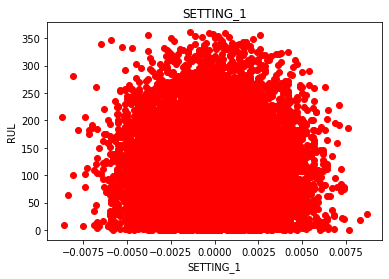

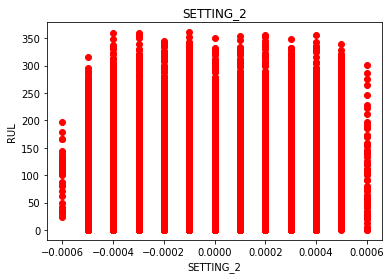

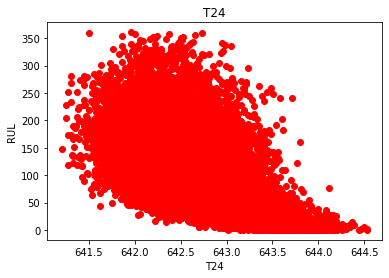

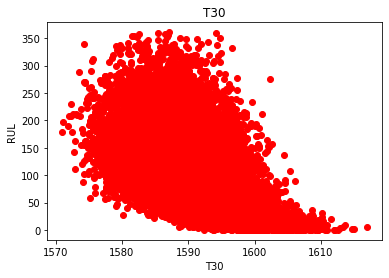

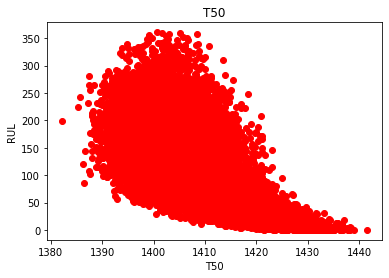

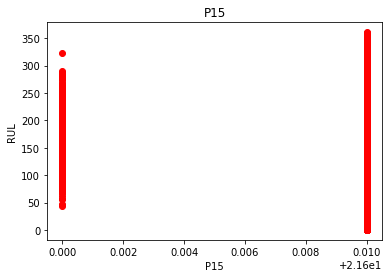

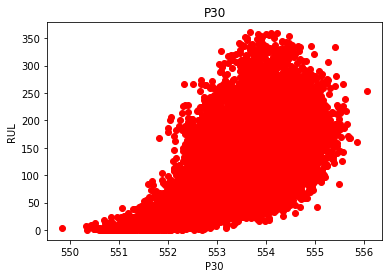

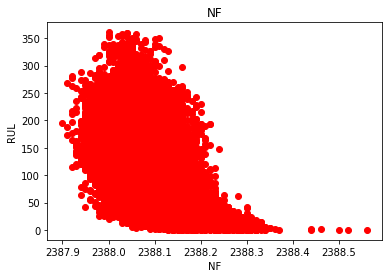

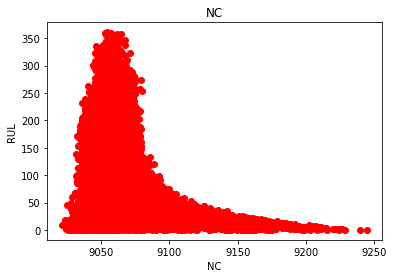

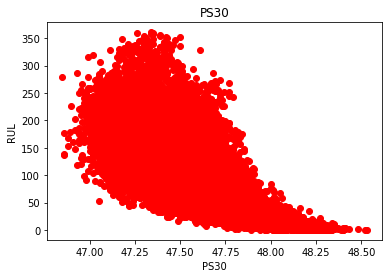

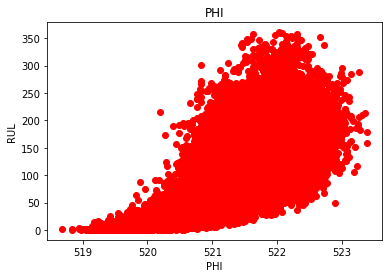

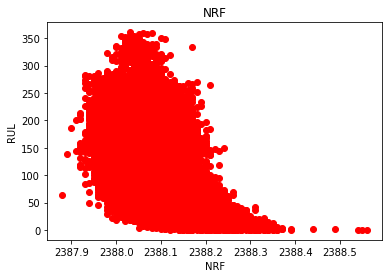

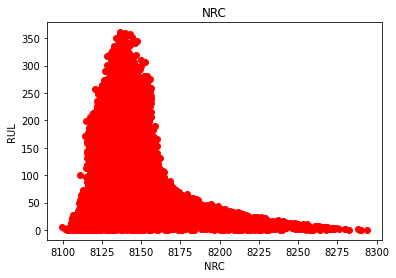

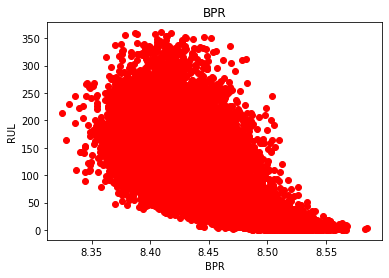

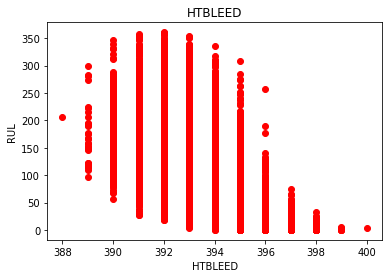

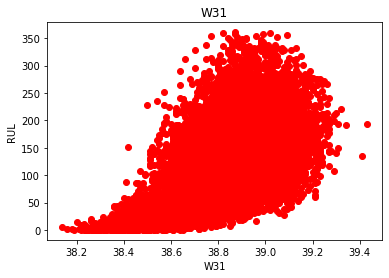

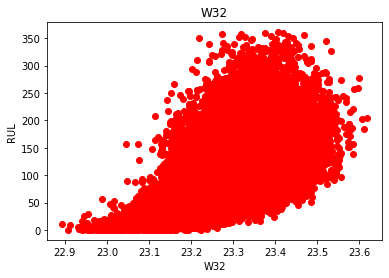

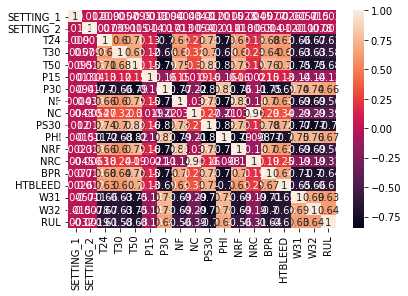

In [3]:
train_df = pd.read_csv(train_filename)
utils.trainDataPlot(train_df)
utils.trainDataCorrelation(train_df)

X_train = train_df.drop(columns = utils.COLUMNSTOREMOVE, axis=1, inplace=False)
X_train.drop(columns = ["RUL"], axis=1, inplace=True)                # used for y-value
X_train = X_train.values
y_train = train_df.RUL.values


### STEP 2: TRAINING DATA - Create Model

In [4]:
model = xgb.XGBRegressor(n_estimators=85, learning_rate=0.018, gamma=0, subsample=0.5,
                           colsample_bytree=0.5, max_depth=3,silent=False)
model.fit(X_train,y_train)

[16:18:10] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=85, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### STEP 3: TEST DATA - use trained model to predict Remaining Useful Cycles (RUL)

In [5]:

# true_RUL: The 'true' RUL test values are provided, which will be used to compare against
true_RUL = pd.read_csv(test_RUL_filename, names=["RUL"])

# makeTestData() will provide the following results:
#   pred_RUL: The predicted RUL for each point that corresponds to its given x values
#   X_test  : Combined dataset that has both X and Y values
pred_RUL, X_test = utils.makeTestData(test_filename, model)


### STEP 4: Calculations

In [6]:

# Classification Predictive Modeling
train_df['willFail'] = np.where(train_df['RUL'] <= Cycle_Alert_Threshold, 1, 0 )
train_y = train_df['willFail']


model = xgb.XGBRFClassifier()
model.fit(X_train, train_y)

true_RUL_class = pd.DataFrame()
true_RUL_class['willFail'] = np.where(true_RUL['RUL'] <= Cycle_Alert_Threshold, 1, 0)
true_RUL_class = true_RUL_class.values

pred_fail = model.predict(X_test)

accuracy = "{:.2f}%".format(accuracy_score(true_RUL_class, pred_fail) * 100)

# Cost-Benefit: Confusion Matrix
#                     Positive (1)  Negative (0)
#                   +-------------+-------------+
#                   |             |             |
#     Positive (1)  |      TP     |      FP     |
#                   |   ($500K)   |  (-$150K)   |
#                   |             |             |
#                   +-------------+-------------+
#                   |             |             |
#     Negative (0)  |      FN     |      TN     |
#                   |   (-$1M)    |    ($0)     |
#                   |             |             |
#                   +-------------+-------------+
y_real = np.transpose(np.squeeze(true_RUL_class))
y_pred = np.array(pred_fail)
AUC = "{:.2f}".format(roc_auc_score(y_real, y_pred))

tn,fp,fn,tp = confusion_matrix(y_real,y_pred).ravel()
#Model predicts life remaining above cycle alert threshold and test data indicates
# cycles were correctly above threshold
tn_cost = 0

#Model predicts life remaining below cycle alert threshold and test data indicates
# cycles were above threshold (Engine is pulled too early)
fp_cost = fp * -150000

#Model predicts life remaining above cycle alert threshold and test data indicates
# cycles were below threshold (Engine pulled too late)
fn_cost = fn * -1000000

#Model predicts life remaining below cycle alert threshold and test data indicates
# cycles were correctly below threshold
tp_cost = tp * 500000

#Add up the costs
savings = tn_cost + fp_cost + fn_cost + tp_cost
if (savings >= 0):
  savings = "+${:,.2f}".format(savings)
else:
  savings = "-${:,.2f}".format(savings)


#cdsw.track_metric('Accuracy', accuracy)
#cdsw.track_metric('Savings', savings)
#cdsw.track_metric('AUC', AUC)

print(f"Accuracy: {accuracy}")
print(f"Savings: {savings}")
print(f"AUC: {AUC}")


Accuracy: 93.00%
Savings: +$4,850,000.00
AUC: 0.89
